In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import scipy
from scipy.stats import chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import  accuracy_score, mean_squared_error, mean_absolute_error, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
import datetime

## Load data

In [2]:
df = pd.read_csv('avocado.csv', index_col = 0)
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0  2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1  2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2  2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3  2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4  2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25          0.0  conventional  2015  Albany  
1     9505.56     9408.07       97.49          0.0  conventional  2015  Albany  
2     8145.35     8042.21      103.14          0.0  conventional  2015  Albany  
3     5811.16     5677.40      133.76          0.0  conventional  2015  Albany  
4     6183.95     5986.26      197.69          0.0  conventional  2015  Albany

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


No null value but feature type are wrong

In [4]:
report = pp.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Data Understanding

### Data Collection

- Data was taken from retailer's cash register.
- Time: April/2015 - March/2018.

### Data Understanding

- Current features:
    - Date: Date of transaction.
    - Type: type of avocado ((Conventional/organic).
    - Region: conpany's market.
    - Total Volume: Total of avocado sale volume.
        - 4046: Total of PLU 4046 has been solded.
        - 4225: Total of PLU 4225 has been solded.
        - 4770: Total of PLU 4770 has been solded.
    - Total Bags: Total of bas solded.
        - Small Bags: Total of small bags size has been solded.
        - Large Bags: Total of Large bags size has been solded.
        - Xlarge Bags: Total of Xlarge bags size has been solded.

- Additional features:
    - Month: Month of transaction.
    - Season: Season of transaction.
    

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df['month'] = pd.DatetimeIndex(df['Date']).month

- US season function:
    - Spring: Mar - May
    - Summer: Jun - Aug
    - Fall: Sep - Nov
    - Winter: Dec - Feb

In [7]:
def season(m):
    if m == 3 or m ==4 or m ==5:
        return 0#spring
    elif m == 6 or m==7 or m==8:
        return 1#summer
    elif m==9 or m ==10 or m==11:
        return 2 #fall
    else:
        return 3#winter

In [8]:
#Create new season feature
df['season'] = df['month'].apply(lambda x: season(x))

In [9]:
#rename avocados type columns
df =df.rename(columns = {
    '4046':'Small_hass',
    '4225':'Large_hass',
    '4770':'Xlarge_hass'
})

### Single vaiable analysis

In [10]:
objs = ['type', 'region', 'month', 'season']
i = 1
for obj in objs:
  print(i, '/', obj, '\t', len(df[obj].unique()), df[obj].unique())
  i +=1

1 / type 	 2 ['conventional' 'organic']
2 / region 	 54 ['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']
3 / month 	 12 [12 11 10  9  8  7  6  5  4  3  2  1]
4 / season 	 4 [3 2 1 0]


In [11]:
#Categorical
def single_categorical(a):
    #categorical_count = df[a].value_counts()
    #print(categorical_count)
    plt.figure(figsize = (25,12))
    ax = sns.barplot(y = df[a].value_counts(), x = df[a].unique())
    for value in ax.patches:      #Annotate the value
      ax.annotate(format(value.get_height()),
                  (value.get_x() + value.get_width()/2,
                  value.get_height()), ha = 'center', va = 'center',
                  size = 15, xytext = (0,8),
                  textcoords = 'offset points', rotation = 45)
      ax.tick_params(axis='x', rotation=90, labelsize = 15)
      ax.tick_params(axis='y', labelsize = 15)
    plt.show()

==================== type ====================


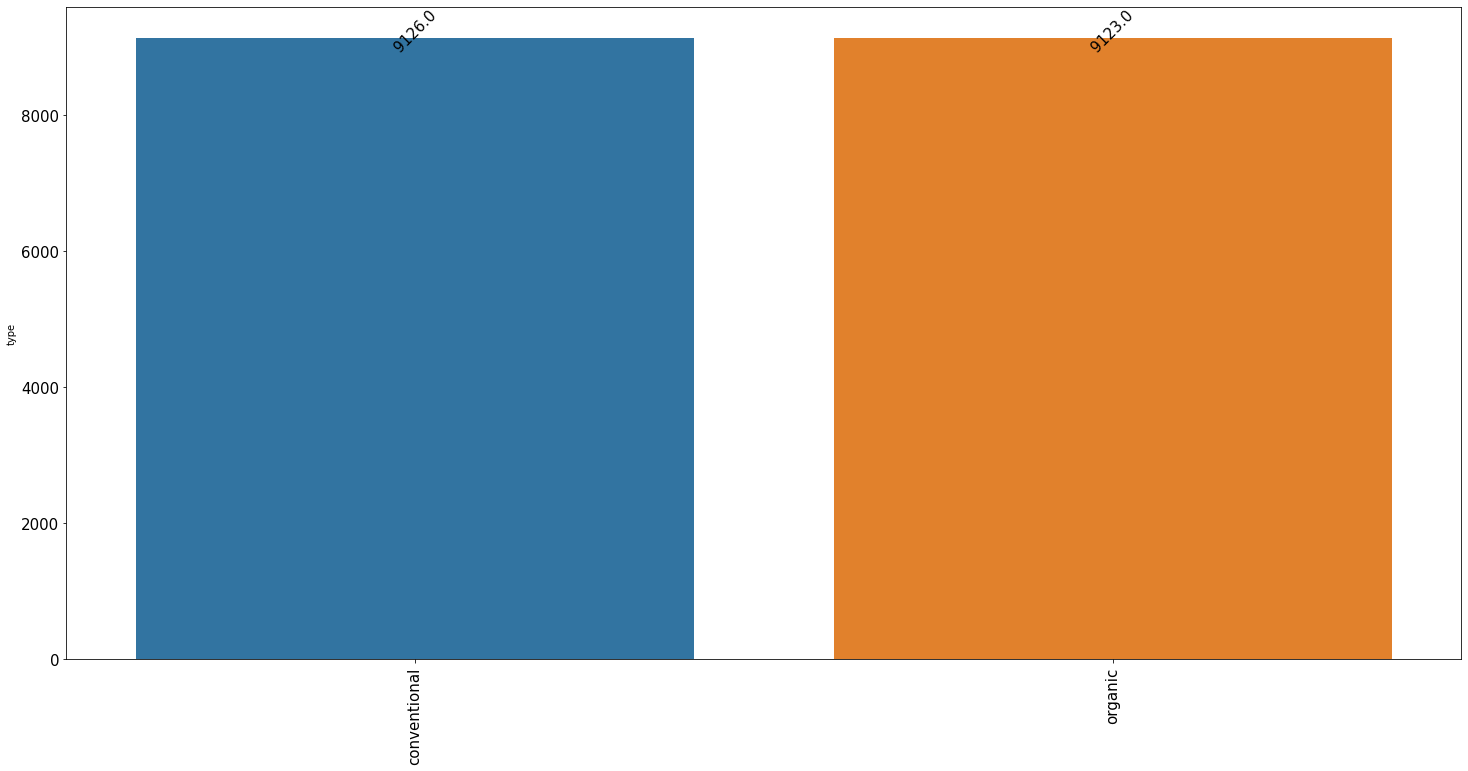

==================== region ====================


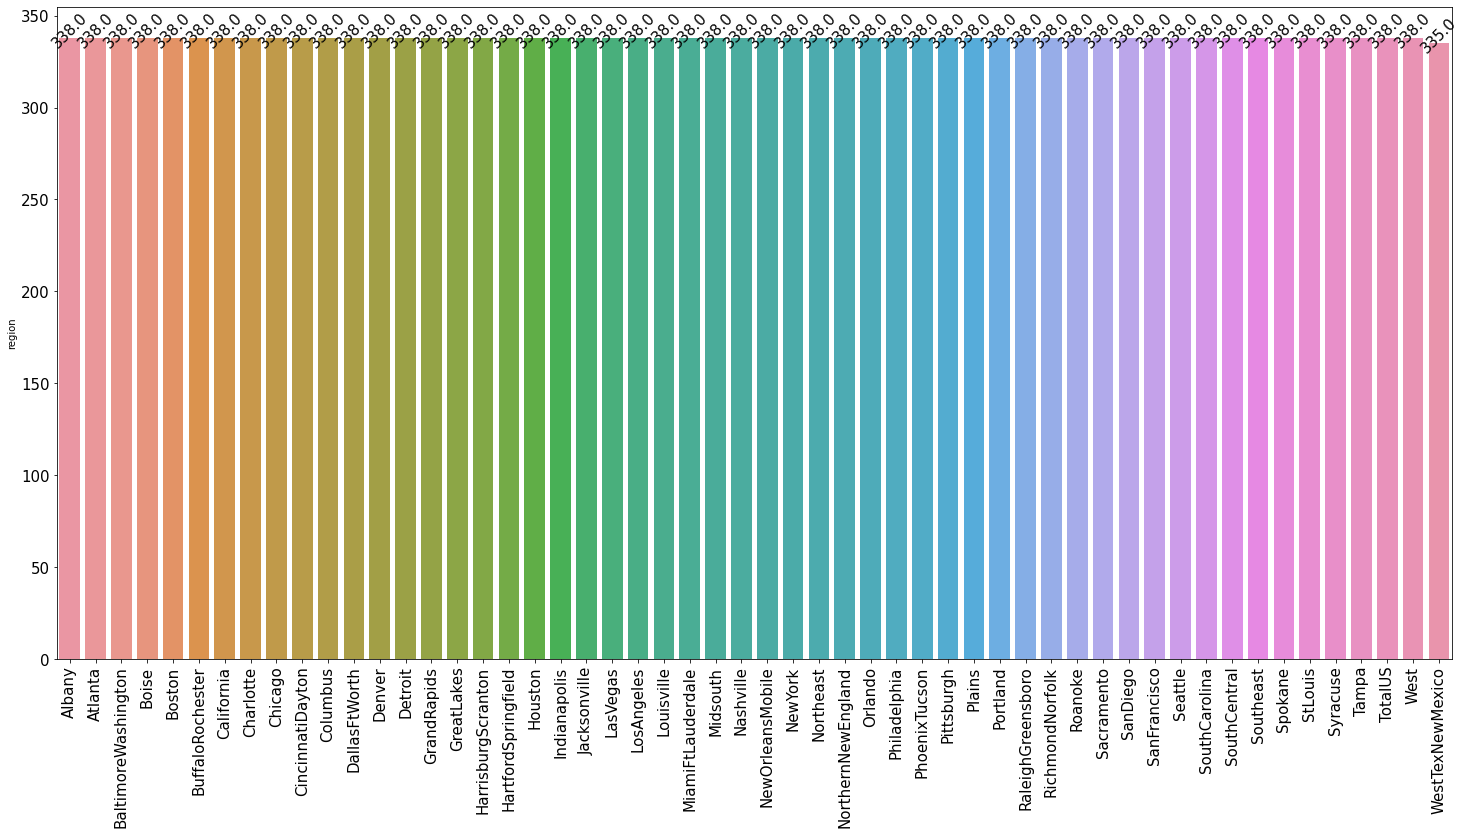

==================== month ====================


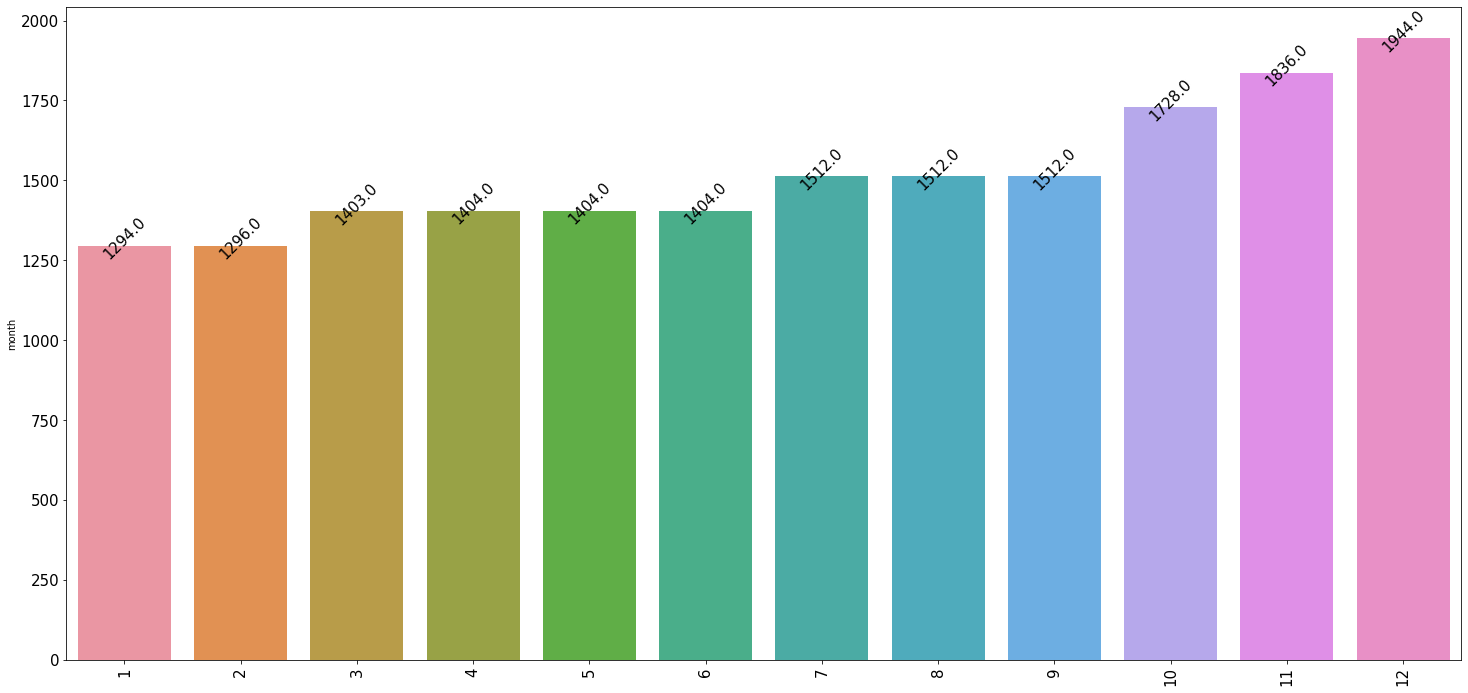

==================== season ====================


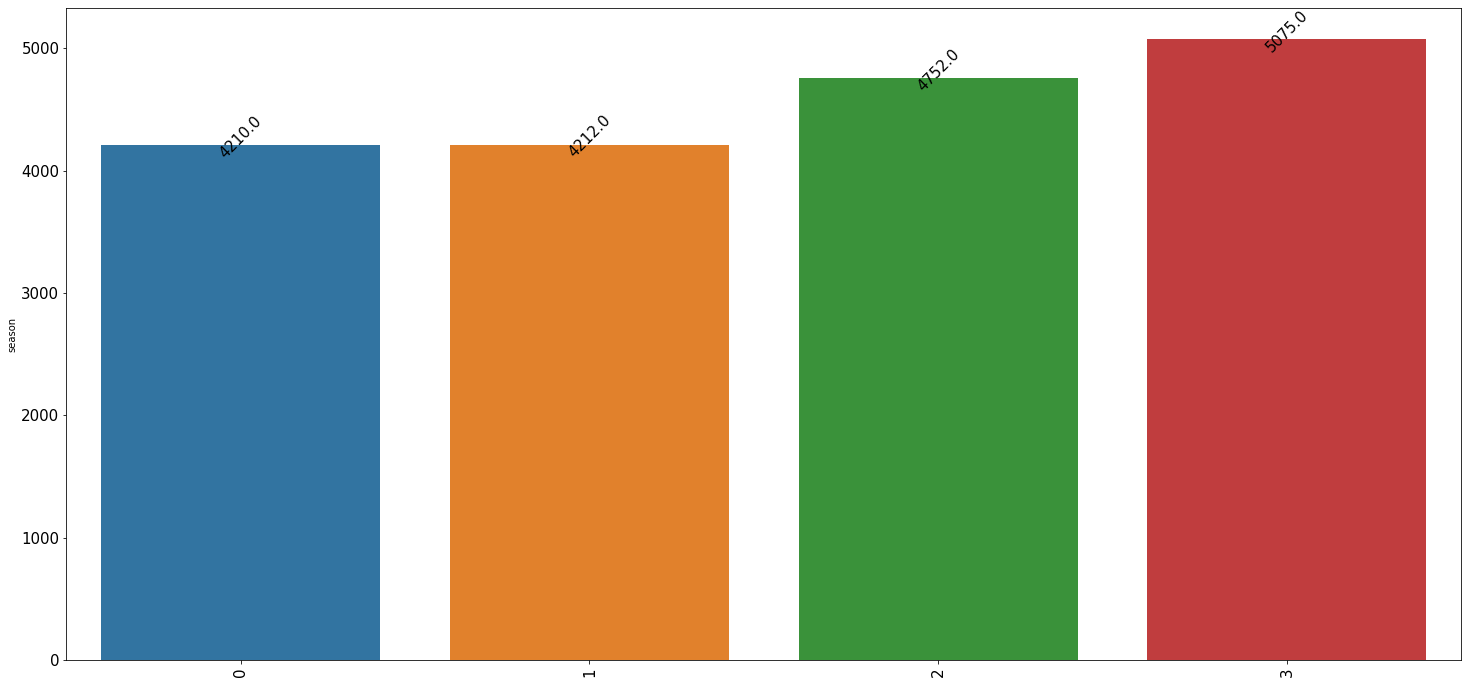

In [12]:
for obj in objs:
  print('====================', obj, '====================')
  single_categorical(obj)

- As a result:
    - The type feature have 2 values conventional (9126) and organic(9123). Those 2 value are balance for making a prediction is good, or separate into 2 difference data is prefered.
    - The region feature's value have the same value count except WestTextNewMexico, but it is accepted. Region contain 54 region (TotalUS is contained) those region are variety because some are single region (city/state) and some are conbined region (combination of cities/states).
         - Combined region: TotalUS, Northeast, MidSouth, SouthCentral, Southeast, West, GreatLakes, NorthernNewEngland.
         - Region: the rest.
    - Season and month are the same, the moment avocados transaction have the most begining from September (Autumn) until the first month of winter season (December).

In [13]:
#take all numerical feature, except object and datetime.
nums = [f for f in df.columns if df.dtypes[f] != 'object' and df.dtypes[f] != 'datetime64[ns]']
i = 1
for num in nums:
  print(i, '/', num, '\t', len(df[num].unique()), df[num].unique())
  i +=1

1 / AveragePrice 	 259 [1.33 1.35 0.93 1.08 1.28 1.26 0.99 0.98 1.02 1.07 1.12 1.31 1.11 1.34
 1.45 1.05 1.37 1.27 1.32 1.23 1.19 1.43 1.2  1.22 1.13 1.16 1.06 1.17
 1.24 0.96 1.   1.09 0.95 0.97 1.15 1.01 1.14 1.1  1.04 1.03 1.18 1.29
 1.25 0.71 0.94 0.91 1.39 1.4  1.36 1.3  1.54 1.59 1.56 1.38 1.49 1.5
 1.47 1.42 1.41 1.44 1.52 0.9  0.87 0.78 0.92 0.83 0.88 0.84 0.85 1.21
 0.79 0.89 0.86 0.8  0.82 0.74 0.81 0.77 0.75 0.65 0.73 0.68 0.72 0.67
 0.76 0.62 0.7  0.66 1.46 0.49 0.53 0.56 0.6  0.58 0.54 0.52 0.51 0.57
 0.63 0.64 0.61 1.48 1.55 1.58 1.53 1.57 1.51 0.69 1.62 1.63 1.61 1.6
 1.73 1.8  1.86 1.85 1.69 1.66 1.65 1.64 1.67 1.68 1.82 2.07 1.84 1.83
 1.7  1.72 1.81 1.78 0.59 1.9  1.93 1.99 1.95 1.89 1.76 1.71 1.74 0.55
 1.79 1.75 1.94 2.2  1.87 1.77 2.06 2.11 2.22 2.14 2.15 2.02 2.   1.88
 1.96 2.19 2.09 1.98 1.97 1.92 2.04 0.46 2.01 2.08 2.03 2.05 2.28 2.35
 2.29 1.91 2.18 2.24 2.12 2.13 2.16 2.32 2.34 2.33 2.31 2.23 2.27 2.3
 2.41 2.36 2.37 2.39 2.42 2.45 2.38 2.4  2.25 2.26 2.17 2

In [14]:
#Continuous
def single_continuous(a):
    print(df[a].describe())
    print('Giá trị trung vị: ', df[a].median())
    print('Giá trị mode: ', df[a].mode())
    print('Measure of Dispersion: ',np.ptp(df[a]))
    print('==================================')
    Q1 = np.percentile(df[a], 25)
    Q3 = np.percentile(df[a], 75)
    print('Q1 = ', Q1,'\n','Q3 = ', Q3)
    print('==================================')
    print('Phương sai (Variance) = ', df[a].var())
    print('Độ lệch chuẩn (std) = ', df[a].std())
    print('==================================')
    print('Skew = ', df[a].skew())
    print('scipy Skew = ', scipy.stats.skew(df[a]))
    print('==================================')
    print('Kurtoisis = ',df[a].kurtosis())
    print('scipy kurtosis = ', scipy.stats.kurtosis(df[a]))
    print('==================================')
    plt.figure(figsize =(10,8))
    plt.subplot(1,2,1)
    sns.distplot(df[a])
    plt.subplot(1,2,2)
    plt.hist(df[a])
    plt.xticks(rotation = 30)
    plt.ticklabel_format(style='plain')
    plt.show()
    print('==================================')
    plt.figure(figsize = (4,8))
    plt.boxplot(df[a])
    plt.show()

===================== AveragePrice =====================
count    18249.000000
mean         1.405978
std          0.402677
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.250000
Name: AveragePrice, dtype: float64
Giá trị trung vị:  1.37
Giá trị mode:  0    1.15
dtype: float64
Measure of Dispersion:  2.81
Q1 =  1.1 
 Q3 =  1.66
Phương sai (Variance) =  0.1621484083457613
Độ lệch chuẩn (std) =  0.40267655549555065
Skew =  0.5803027378878419
scipy Skew =  0.5802550380696565
Kurtoisis =  0.3251958506534338
scipy kurtosis =  0.3247779907295181


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


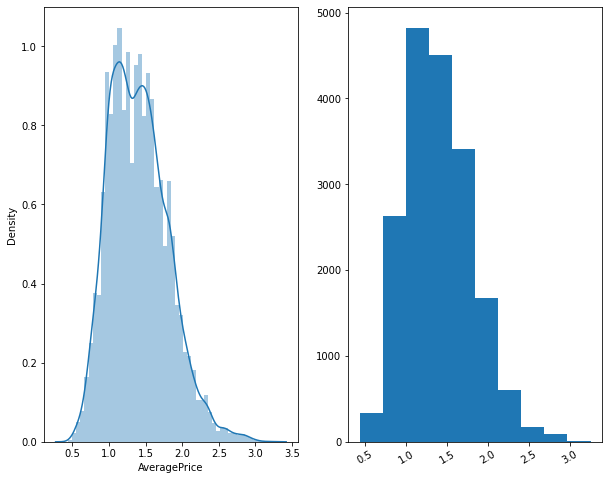

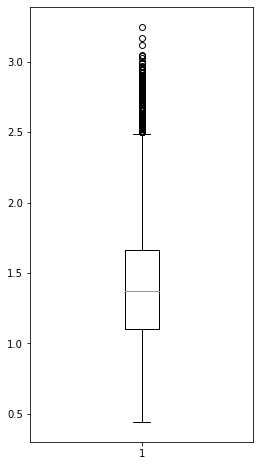

===================== Total Volume =====================
count    1.824900e+04
mean     8.506440e+05
std      3.453545e+06
min      8.456000e+01
25%      1.083858e+04
50%      1.073768e+05
75%      4.329623e+05
max      6.250565e+07
Name: Total Volume, dtype: float64
Giá trị trung vị:  107376.76
Giá trị mode:  0       2038.99
1       2858.31
2       3288.85
3       3529.44
4       3713.49
5       4103.97
6       7223.46
7       9465.99
8      13234.04
9      19634.24
10     46602.16
11    569349.05
dtype: float64
Measure of Dispersion:  62505561.96
Q1 =  10838.58 
 Q3 =  432962.29
Phương sai (Variance) =  11926975521801.262
Độ lệch chuẩn (std) =  3453545.3553994712
Skew =  9.00768747885452
scipy Skew =  9.006947063504116
Kurtoisis =  92.10445777646086
scipy kurtosis =  92.07889546445338


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


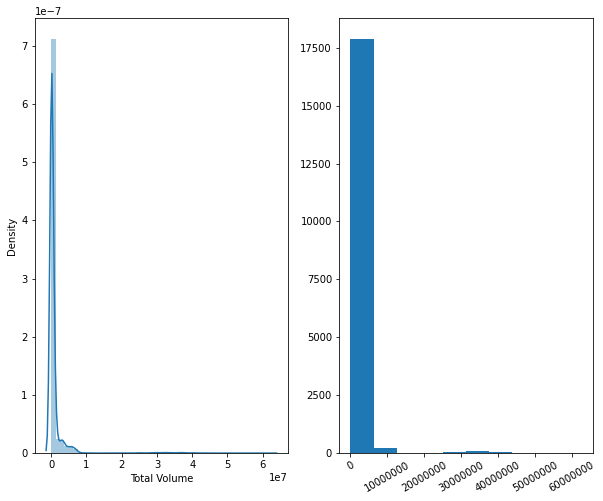

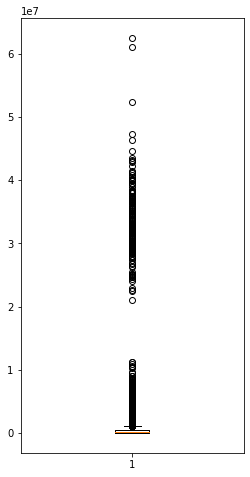

===================== Small_hass =====================
count    1.824900e+04
mean     2.930084e+05
std      1.264989e+06
min      0.000000e+00
25%      8.540700e+02
50%      8.645300e+03
75%      1.110202e+05
max      2.274362e+07
Name: Small_hass, dtype: float64
Giá trị trung vị:  8645.3
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  22743616.17
Q1 =  854.07 
 Q3 =  111020.2
Phương sai (Variance) =  1600197376979.0344
Độ lệch chuẩn (std) =  1264989.0817627772
Skew =  8.648219757025226
scipy Skew =  8.647508889260688
Kurtoisis =  86.80911256453511
scipy kurtosis =  86.78500100023633


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


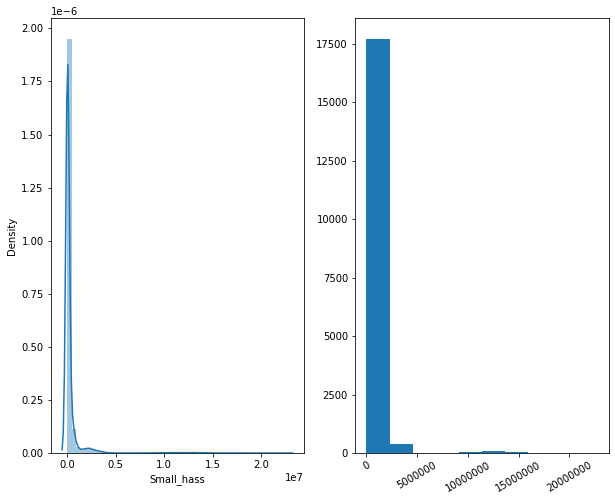

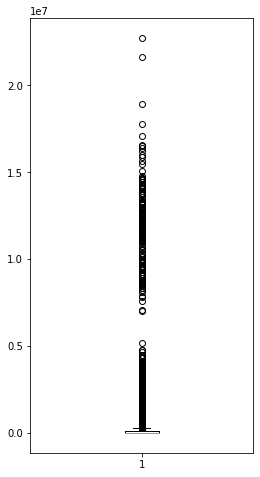

===================== Large_hass =====================
count    1.824900e+04
mean     2.951546e+05
std      1.204120e+06
min      0.000000e+00
25%      3.008780e+03
50%      2.906102e+04
75%      1.502069e+05
max      2.047057e+07
Name: Large_hass, dtype: float64
Giá trị trung vị:  29061.02
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  20470572.61
Q1 =  3008.78 
 Q3 =  150206.86
Phương sai (Variance) =  1449905940429.6353
Độ lệch chuẩn (std) =  1204120.4011350507
Skew =  8.942465607536276
scipy Skew =  8.941730553303788
Kurtoisis =  91.94902196597442
scipy kurtosis =  91.92350223818701


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


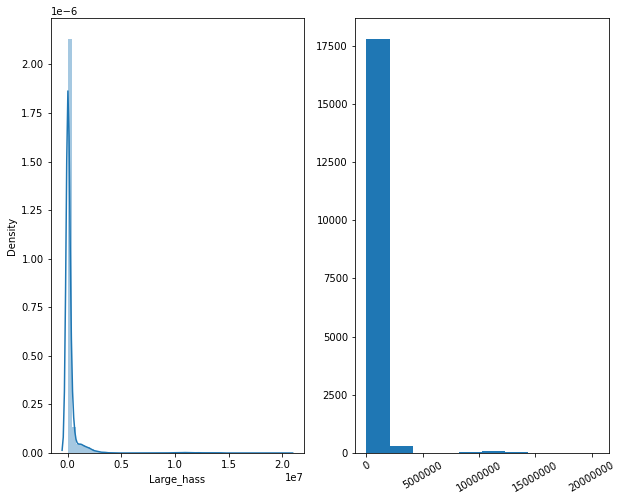

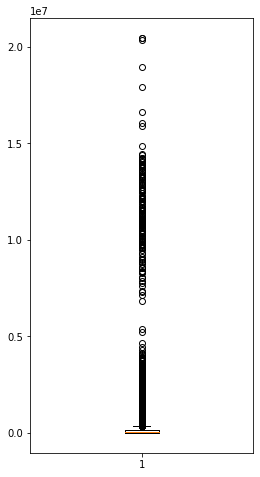

===================== Xlarge_hass =====================
count    1.824900e+04
mean     2.283974e+04
std      1.074641e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.849900e+02
75%      6.243420e+03
max      2.546439e+06
Name: Xlarge_hass, dtype: float64
Giá trị trung vị:  184.99
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  2546439.11
Q1 =  0.0 
 Q3 =  6243.42
Phương sai (Variance) =  11548526004.682043
Độ lệch chuẩn (std) =  107464.06843537073
Skew =  10.15939562715204
scipy Skew =  10.158560543509228
Kurtoisis =  132.5634408664653
scipy kurtosis =  132.52679414453434


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


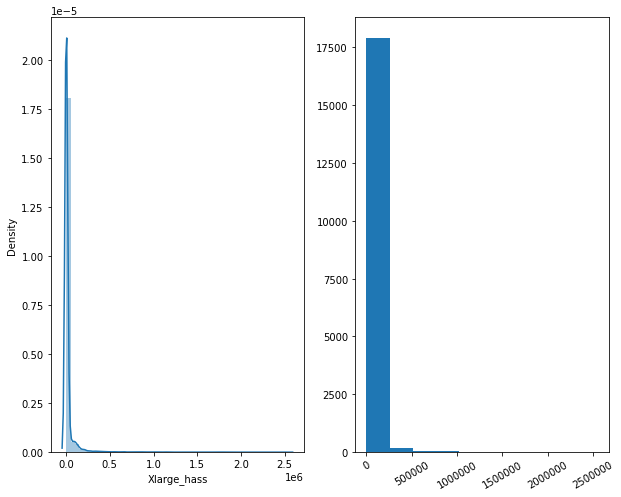

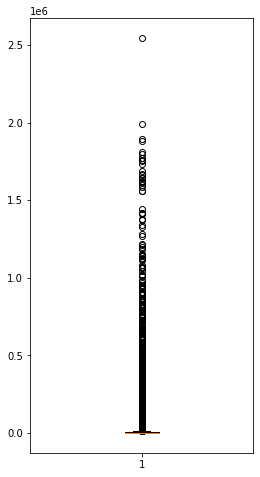

===================== Total Bags =====================
count    1.824900e+04
mean     2.396392e+05
std      9.862424e+05
min      0.000000e+00
25%      5.088640e+03
50%      3.974383e+04
75%      1.107834e+05
max      1.937313e+07
Name: Total Bags, dtype: float64
Giá trị trung vị:  39743.83
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  19373134.37
Q1 =  5088.64 
 Q3 =  110783.37
Phương sai (Variance) =  972674070012.1442
Độ lệch chuẩn (std) =  986242.3992164118
Skew =  9.756071670300289
scipy Skew =  9.755269739145234
Kurtoisis =  112.27215647043404
scipy kurtosis =  112.24106888264194


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


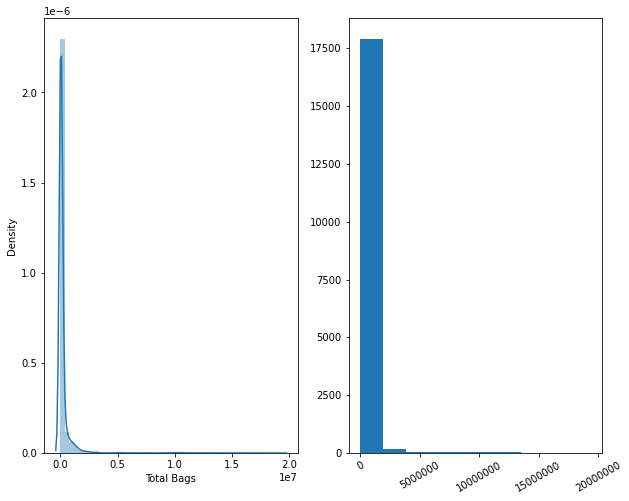

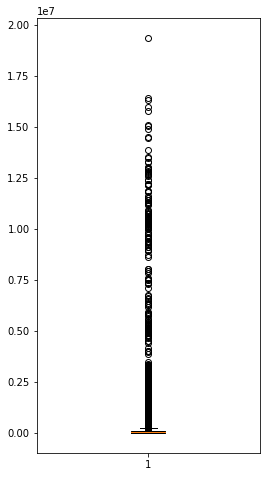

===================== Small Bags =====================
count    1.824900e+04
mean     1.821947e+05
std      7.461785e+05
min      0.000000e+00
25%      2.849420e+03
50%      2.636282e+04
75%      8.333767e+04
max      1.338459e+07
Name: Small Bags, dtype: float64
Giá trị trung vị:  26362.82
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  13384586.8
Q1 =  2849.42 
 Q3 =  83337.67
Phương sai (Variance) =  556782376190.5807
Độ lệch chuẩn (std) =  746178.5149617889
Skew =  9.540659981758614
scipy Skew =  9.539875757048327
Kurtoisis =  107.01288512522609
scipy kurtosis =  106.9832384021082


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


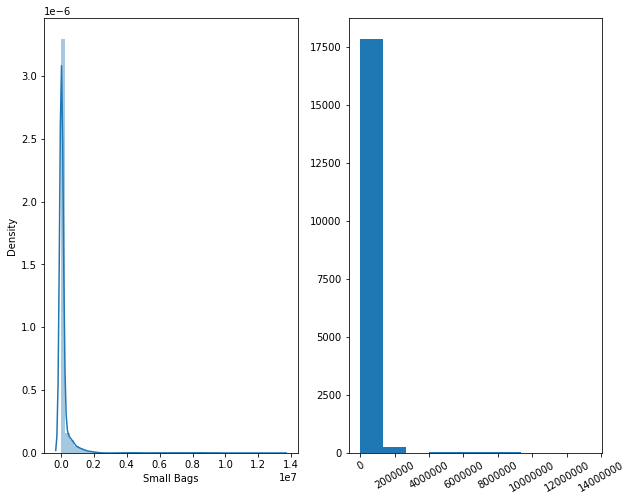

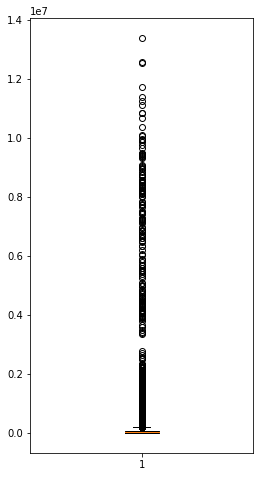

===================== Large Bags =====================
count    1.824900e+04
mean     5.433809e+04
std      2.439660e+05
min      0.000000e+00
25%      1.274700e+02
50%      2.647710e+03
75%      2.202925e+04
max      5.719097e+06
Name: Large Bags, dtype: float64
Giá trị trung vị:  2647.71
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  5719096.61
Q1 =  127.47 
 Q3 =  22029.25
Phương sai (Variance) =  59519391857.54754
Độ lệch chuẩn (std) =  243965.96454740883
Skew =  9.796454598705258
scipy Skew =  9.79564934814773
Kurtoisis =  117.99948104584172
scipy kurtosis =  117.96682436242466


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


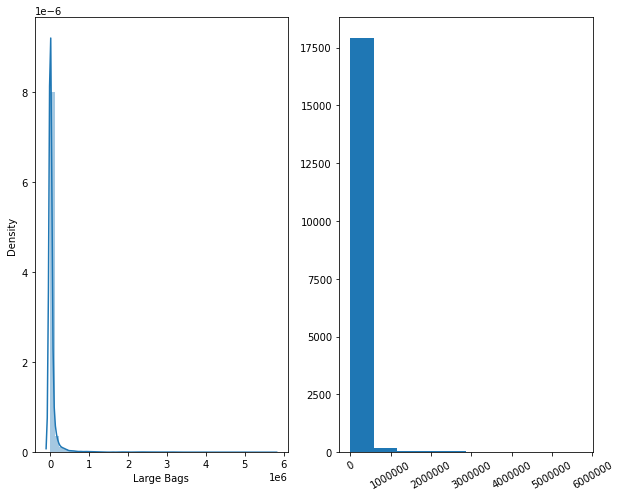

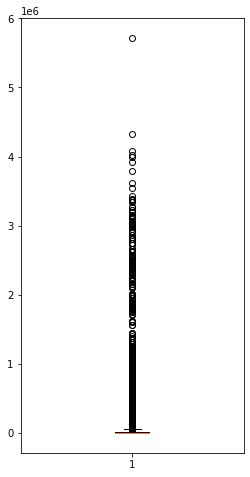

===================== XLarge Bags =====================
count     18249.000000
mean       3106.426507
std       17692.894652
min           0.000000
25%           0.000000
50%           0.000000
75%         132.500000
max      551693.650000
Name: XLarge Bags, dtype: float64
Giá trị trung vị:  0.0
Giá trị mode:  0    0.0
dtype: float64
Measure of Dispersion:  551693.65
Q1 =  0.0 
 Q3 =  132.5
Phương sai (Variance) =  313038521.16381496
Độ lệch chuẩn (std) =  17692.894651916486
Skew =  13.13975068600658
scipy Skew =  13.138670622657223
Kurtoisis =  233.60261186166983
scipy kurtosis =  233.53828378187717


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


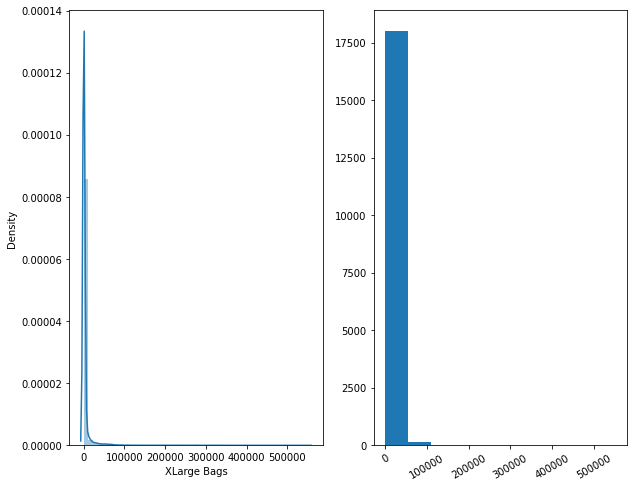

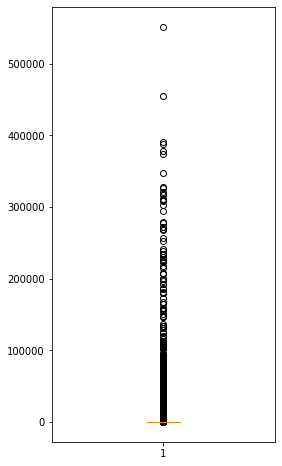

===================== year =====================
count    18249.000000
mean      2016.147899
std          0.939938
min       2015.000000
25%       2015.000000
50%       2016.000000
75%       2017.000000
max       2018.000000
Name: year, dtype: float64
Giá trị trung vị:  2016.0
Giá trị mode:  0    2017
dtype: int64
Measure of Dispersion:  3
Q1 =  2015.0 
 Q3 =  2017.0
Phương sai (Variance) =  0.8834843220106178
Độ lệch chuẩn (std) =  0.9399384671405984
Skew =  0.2153386867532291
scipy Skew =  0.21532098630907168
Kurtoisis =  -1.0327470807452306
scipy kurtosis =  -1.0327929096650357


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


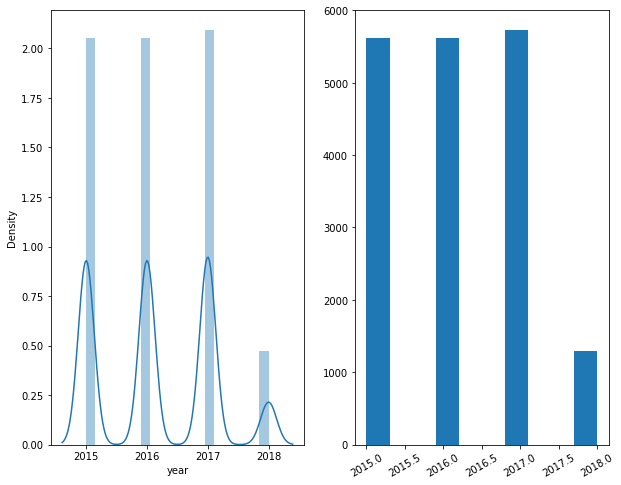

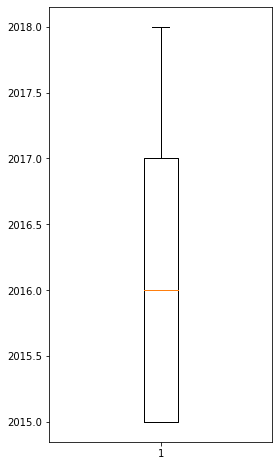

===================== month =====================
count    18249.000000
mean         6.177215
std          3.534130
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: month, dtype: float64
Giá trị trung vị:  6.0
Giá trị mode:  0    1
dtype: int64
Measure of Dispersion:  11
Q1 =  3.0 
 Q3 =  9.0
Phương sai (Variance) =  12.490074861680696
Độ lệch chuẩn (std) =  3.534130000676361
Skew =  0.10661740218025036
scipy Skew =  0.10660863842580401
Kurtoisis =  -1.2652843746247662
scipy kurtosis =  -1.265266496093444


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


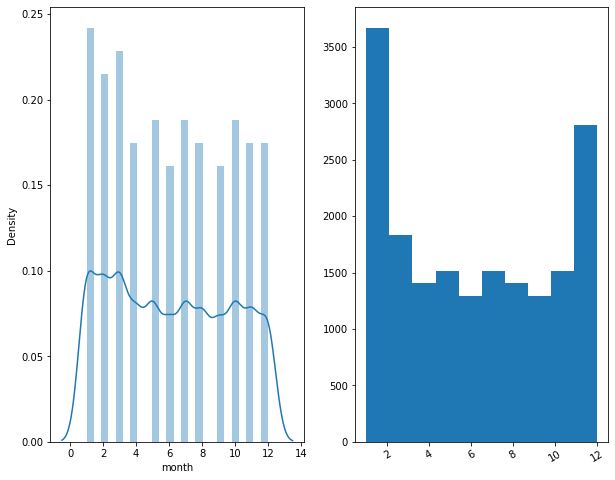

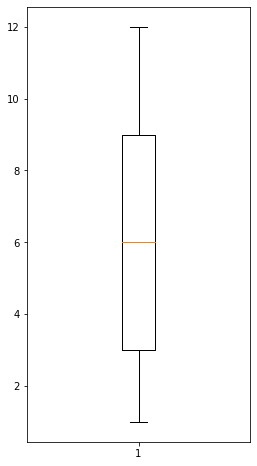

===================== season =====================
count    18249.000000
mean         1.526604
std          1.151675
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: season, dtype: float64
Giá trị trung vị:  2.0
Giá trị mode:  0    3
dtype: int64
Measure of Dispersion:  3
Q1 =  0.0 
 Q3 =  3.0
Phương sai (Variance) =  1.3263554176961017
Độ lệch chuẩn (std) =  1.1516750486556968
Skew =  -0.03019948166480173
scipy Skew =  -0.03019699932292972
Kurtoisis =  -1.434281807249043
scipy kurtosis =  -1.4342176290661692


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


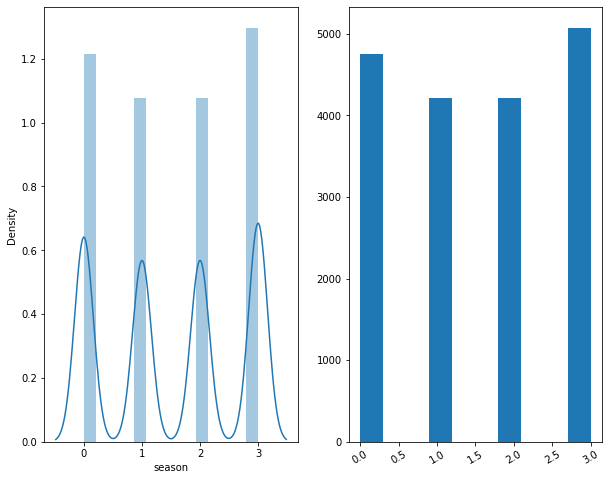

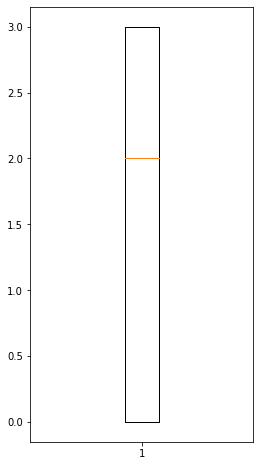

In [15]:
for num in nums:
  print('=====================',num,'=====================')
  single_continuous(num)

- The result showed that most of the feature have outliers which is bad for those regression model such as Linear and KNN (with small k).
    - About skewness: all the feature are strong right skew except "year" (weak left skew).
    - About outliers: all variable have alot of upper outliers axcept time feature such as "year", "month", "season".
- There is a difference between feature's value. So that scale data is suggested but first we must use SelectKBest for choosing which features affect model the most. Then we will decide later.
    -  If scaling is the option, log scale option will be rejected because some feature have 0 value.

### Multivariate analysis

#### Continuous & Continuous
##### Correlation

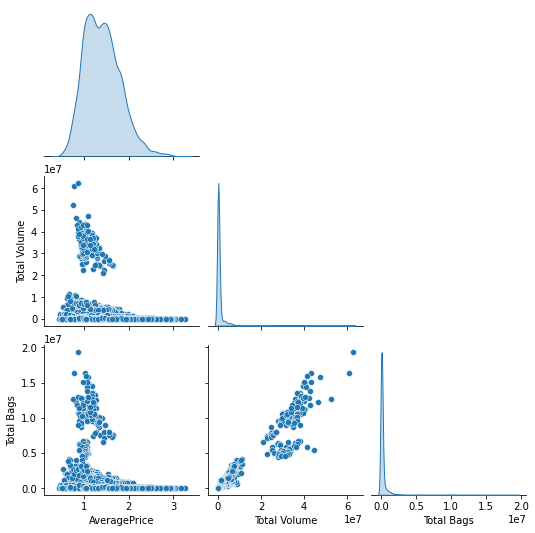

In [17]:
#continuous
sns.pairplot(df[['AveragePrice', 'Total Volume', 'Total Bags']].reset_index(drop = True), diag_kind = 'kde', palette = 'tab10', corner = True)
plt.savefig('pairplot.png')

Result showed that "Total Volume" and "Total Bag" have a strong possitive correlation and those 2 input feature have really weak negative correlation with Average Price. See the chart below for more detail.

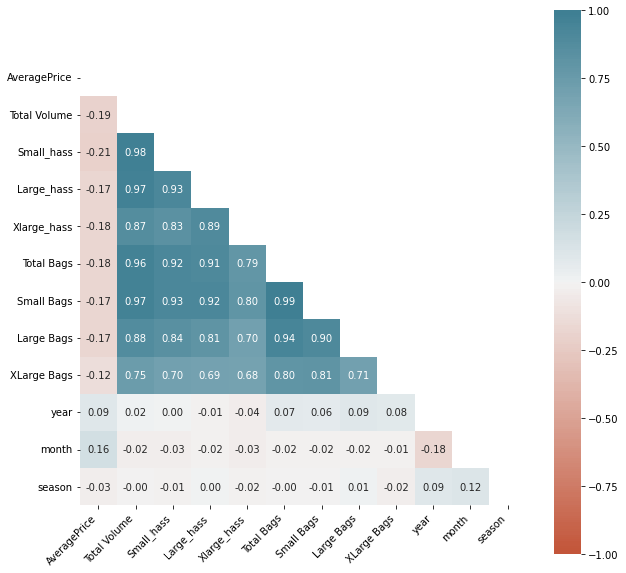

In [18]:
corr = df.corr()
mask = np.triu(corr)#get the upper corr matrix
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr,vmin=-1, vmax=1, center=0,
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    fmt='.2f', mask = mask
)
ax.set_xticklabels( # adding axes values
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig('corrplot.png')

- The Average price have a weak negative effected of all input feature
- All continuous inut have strong correlation with each other, so chosing some feature or just 1 is okay
- The feature impact AveragePrice the most are Total Volume and Total Bags. But we can see those feature have a strong possitive correlation with the other input so that we will select only 2 feature as numeric input. 

#### Continuous & Category
##### ANOVA (relationship)  & tukeyhsd (pair relationship)

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [20]:
def anova(f1, f2, f3, data):
    print('-'*20, 'Anova between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    model = ols('{} ~ C({}) + C({}) + C({}):C({})'.format(f1,f2,f3,f2,f3), data = data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table
def tukeyhsd(f1, f2, f3, data):
    print('-'*20, 'TukeyHSD test between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    print('\n')
    for name, grouped_df in data.groupby(f2):
        print('{} {}'.format(f2, name), pairwise_tukeyhsd(grouped_df[f1],
                                                         grouped_df[f3], alpha = 0.05))

##### Average price with type & region

In [21]:
anova('AveragePrice', 'type', 'region', df)

-------------------- Anova between AveragePrice, type and region --------------------


sum_sq       df             F         PR(>F)
C(type)            1121.987963      1.0  16661.860020   0.000000e+00
C(region)           497.256738     53.0    139.328541   0.000000e+00
C(type):C(region)   117.835096     53.0     33.016731  2.386829e-315
Residual           1221.591324  18141.0           NaN            NaN

In [22]:
tukeyhsd('AveragePrice', 'type', 'region', df)

-------------------- TukeyHSD test between AveragePrice, type and region --------------------


type conventional              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
             Albany             Atlanta  -0.2799  0.001 -0.3715 -0.1884   True
             Albany BaltimoreWashington  -0.0046    0.9 -0.0961   0.087  False
             Albany               Boise  -0.2727  0.001 -0.3642 -0.1812   True
             Albany              Boston  -0.0444    0.9 -0.1359  0.0471  False
             Albany    BuffaloRochester   0.0336    0.9  -0.058  0.1251  False
             Albany          California  -0.2433  0.001 -0.3348 -0.1518   True
             Albany           Charlotte  -0.0737 0.4586 -0.1652  0.0178  False
             Albany             Chicago   0.0206    0.9 -0.0709  0.1121  False
             Alba

type organic              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
             Albany             Atlanta  -0.1662  0.001 -0.2985 -0.0339   True
             Albany BaltimoreWashington  -0.0491    0.9 -0.1813  0.0832  False
             Albany               Boise  -0.1531 0.0037 -0.2854 -0.0208   True
             Albany              Boston  -0.0159    0.9 -0.1482  0.1164  False
             Albany    BuffaloRochester   -0.122 0.1407 -0.2542  0.0103  False
             Albany          California  -0.0881  0.855 -0.2204  0.0442  False
             Albany           Charlotte   0.1637  0.001  0.0314   0.296   True
             Albany             Chicago  -0.0291    0.9 -0.1614  0.1032  False
             Albany    CincinnatiDayton  -0.3704  0.001 -0.5027 -0.2381   True
             Albany            Columbus

##### Average price with type & year

In [23]:
anova('AveragePrice', 'type', 'year', df)

-------------------- Anova between AveragePrice, type and year --------------------


sum_sq       df             F         PR(>F)
C(type)          1122.294219      1.0  11952.219924   0.000000e+00
C(year)           103.340697      3.0    366.852920  2.286246e-231
C(type):C(year)    20.541911      3.0     72.922483   7.066319e-47
Residual         1712.800549  18241.0           NaN            NaN

The result showed that "type", "year" &"type:year" have significantly affect Average Price

In [24]:
tukeyhsd('AveragePrice', 'type', 'year', df)

-------------------- TukeyHSD test between AveragePrice, type and year --------------------


type conventional Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2015   2016   0.0276  0.001  0.0108  0.0445   True
  2015   2017   0.2169  0.001  0.2001  0.2337   True
  2015   2018   0.0499  0.001  0.0224  0.0775   True
  2016   2017   0.1893  0.001  0.1725  0.2061   True
  2016   2018   0.0223 0.1597 -0.0052  0.0498  False
  2017   2018   -0.167  0.001 -0.1945 -0.1395   True
----------------------------------------------------
type organic Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  2015   2016  -0.1016 0.001 -0.1261 -0.0772   True
  2015   2017   0.0622 0.001  0.0378  0.0866   True
  2015   2018  -0.1061 0.001 -0.1461 -0.0662   True
  2016   2017   0.1638 0.001  0.1

Except type = "conventional/organic" (year = 2016, year = 2018), all pair comparison have temporarily reject H0 and show a statistically significant difference.

##### Average price with type & season

In [25]:
anova('AveragePrice', 'type', 'season', df)

-------------------- Anova between AveragePrice, type and season --------------------


sum_sq       df             F    PR(>F)
C(type)            1122.206647      1.0  12174.398685  0.000000
C(season)           152.815098      3.0    552.611212  0.000000
C(type):C(season)     2.456765      3.0      8.884174  0.000007
Residual           1681.411295  18241.0           NaN       NaN

The result showed that "type", "season" & "type:season" significantly affect Average Price with P < 0.01.

In [26]:
tukeyhsd('AveragePrice', 'type', 'season', df)

-------------------- TukeyHSD test between AveragePrice, type and season --------------------


type conventional Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.0813 0.001  0.0622  0.1004   True
     0      2   0.1655 0.001  0.1464  0.1846   True
     0      3  -0.0656 0.001 -0.0838 -0.0473   True
     1      2   0.0841 0.001  0.0645  0.1038   True
     1      3  -0.1469 0.001 -0.1657 -0.1281   True
     2      3   -0.231 0.001 -0.2498 -0.2122   True
---------------------------------------------------
type organic Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1455  0.001  0.1186  0.1725   True
     0      2   0.2083  0.001  0.1814  0.2352   True
     0      3  -0.0247 0.0653 -0.0504   0.001  False
     1      2   0.0628  0.001   0.0

Except type = "organic" (season = 0 & season = 3), all pair comparison have temporarily reject H0 and show a statistically significant difference.

#### Category & Category
##### Use chi-square for testing cateogry features

In [27]:
def two_categorical(table):
  stat, p, dof, expected = chi2_contingency(table)
  print('dof = %d' % dof)
  #print(expected)
  print('==============Interpret test-statistic===============')
  prob = 0.95
  critical = chi2.ppf(prob, dof)
  print('Probability = %.3f, Criticcal = %.3f, Stat = %.3f' %(prob, critical, stat))
  if abs(stat) >= critical:
    print('Dependent (Reject H0)')
  else:
    print('Independent (Fail to reject H0)')
  print('==============Interpret P-value===============')
  alpha = 1-prob
  print('Significance = %.3f, p = %.3f' %(alpha, p))
  if p<alpha:
    print('Dependent (Reject H0)')
  else:
    print('Independent (Fail to reject H0)')

In [28]:
table1 = pd.crosstab(df['year'], df['type'])
table2 = pd.crosstab(df['year'], df['region'])
table3 = pd.crosstab(df['region'], df['type'])
table4 = pd.crosstab(df['type'], df['season'])
table5 = pd.crosstab(df['year'], df['month'])
table6 = pd.crosstab(df['month'], df['season'])

In [29]:
table = [table1, table2, table3, table4, table5, table6]
for i in table:
    print()
    two_categorical(i)


dof = 3
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 7.815, Stat = 0.000
Independent (Fail to reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 1.000
Independent (Fail to reject H0)

dof = 159
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 189.424, Stat = 0.021
Independent (Fail to reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 1.000
Independent (Fail to reject H0)

dof = 53
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 70.993, Stat = 0.026
Independent (Fail to reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 1.000
Independent (Fail to reject H0)

dof = 3
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 7.815, Stat = 0.001
Independent (Fail to reject H0)
==============Interpret P-value===============
Significance = 0.050, 

- The year, month & season feature does not independent with each other, so that we failed to reject H0.
- The rest feature are significant so we temporary accepted H1.

### Data Visualization

In [30]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', 'Small_hass', 'Large_hass',
       'Xlarge_hass', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags',
       'type', 'year', 'region', 'month', 'season'],
      dtype='object')

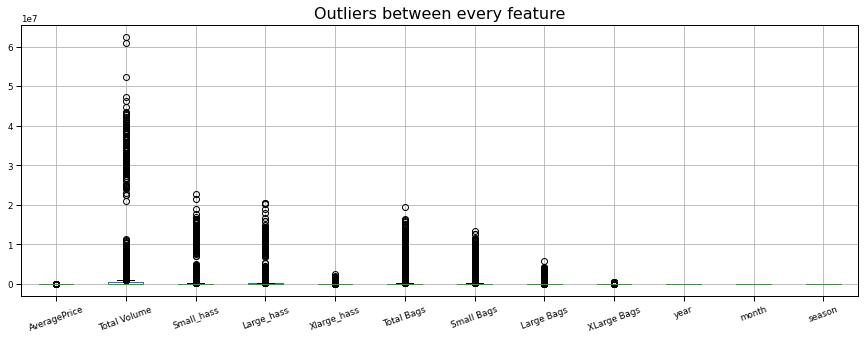

In [45]:
plt.figure(figsize = (15,5))
df.boxplot()
plt.xticks(rotation = 20)
plt.title('Outliers between every feature', size = 16)
plt.savefig('boxplot.png')
plt.show()


All continuous have upper outliers

In [32]:
total = df.groupby(['region', 'year']).sum().reset_index()

In [33]:
total = total[total['region'] != 'TotalUS']

<AxesSubplot:xlabel='Total Volume', ylabel='region'>

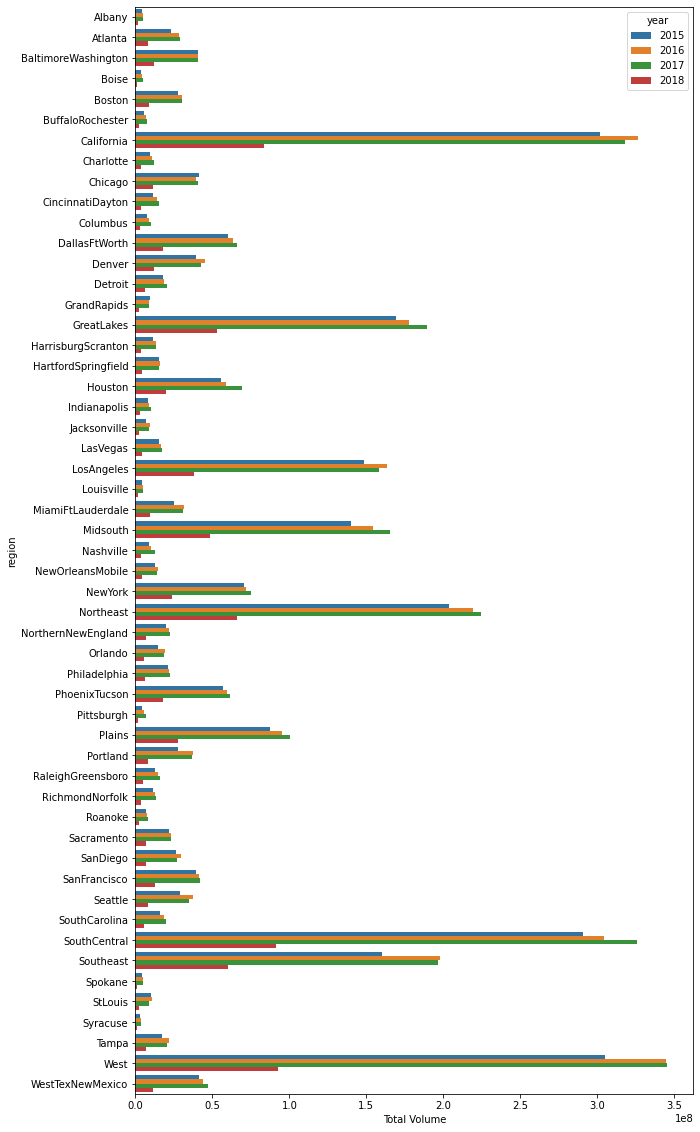

In [34]:
plt.figure(figsize = (10, 20))
sns.barplot(x="Total Volume",  y= 'region', 
            data=total, ci = 0, hue = 'year')

As the result showed, the combined region have the Total Volume higher than the other, the West and California still on top region through many year. In fact, there are some potential region have a good growth such as DalasFtWorth, Houston, Plains.

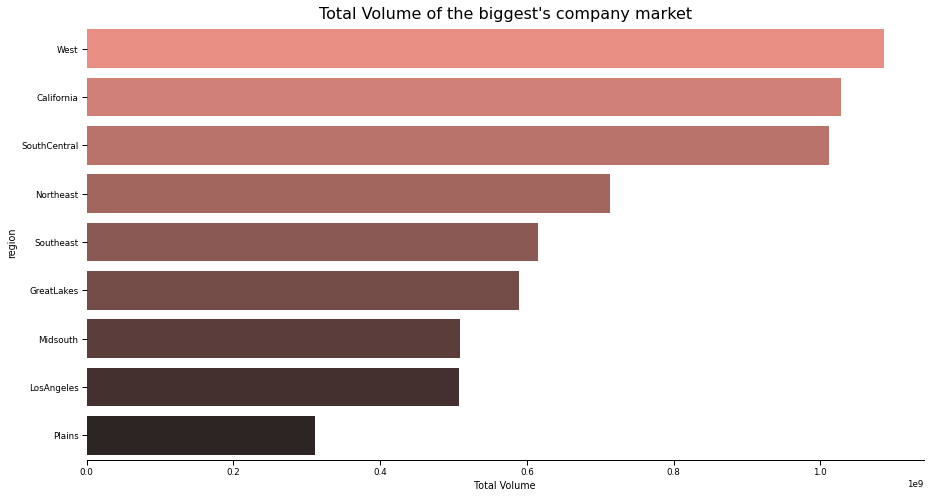

In [48]:
#Create dataframe showed Top 10 region have highest Sum "Total Volume"
volume = df.groupby(['region']).sum().sort_values(by= 'Total Volume', ascending = False)[1:10]
plt.figure(figsize = (15, 8))
sns.set_context('paper')
sns.barplot(x="Total Volume",  y= volume.index, 
            data=volume, ci = 0, palette= 'dark:salmon_r')
sns.despine(left = True, bottom = False)
plt.title("Total Volume of the biggest's company market" ,size = 16)
plt.savefig('barplot.png')
plt.show()

This plot showed the top Total Volume region of all year.
Top 5 region have a large amount of avocado consume: california, Greatlakes, Northeast, southcentral, southeast.

C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


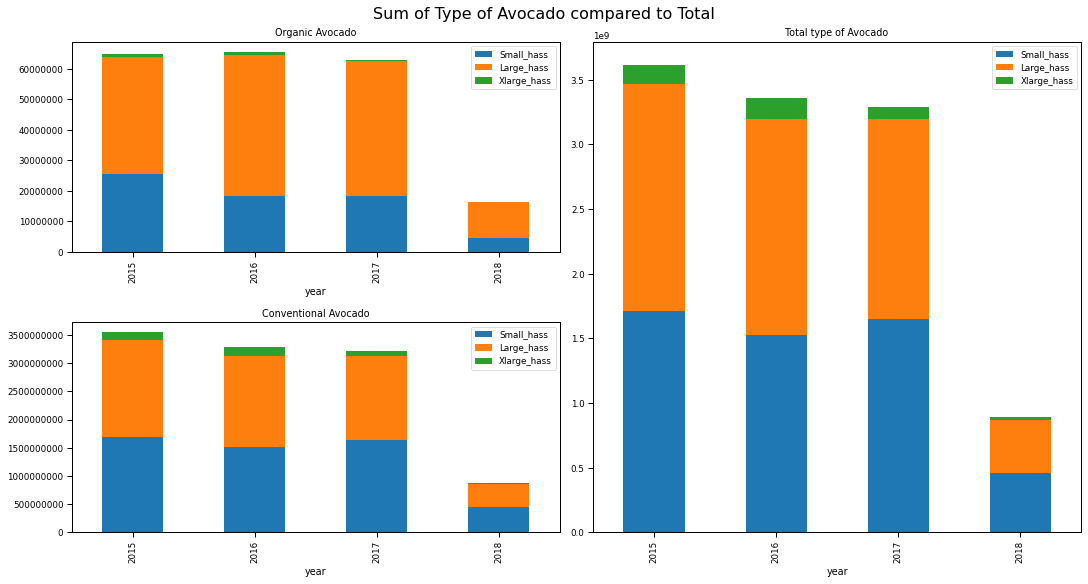

In [49]:
#create avocado data grouped by type and year
avocado_type= df.groupby(['year', 'type']).sum().reset_index()
#create plot for comparing organic, conventional avocado with total for each year
fig = plt.figure(constrained_layout=True, figsize = (15,8))
ax=fig.add_gridspec(2,2)
ax1 = fig.add_subplot(ax[0,0])
avocado_type[avocado_type['type'] == 'organic'][['Small_hass', 'Large_hass', 'Xlarge_hass', 'year']].set_index(['year']).plot(kind = 'bar', stacked = True, ax = ax1)
ax1.set_title('Organic Avocado')
ax1.ticklabel_format(axis = 'y', style='plain')

ax2 = fig.add_subplot(ax[1,0])
avocado_type[avocado_type['type'] == 'conventional'][['Small_hass', 'Large_hass', 'Xlarge_hass', 'year']].set_index(['year']).plot(kind = 'bar', stacked = True, ax = ax2)
ax2.set_title('Conventional Avocado')
ax2.ticklabel_format(axis = 'y', style='plain')

ax3 = fig.add_subplot(ax[0:,-1])
df.groupby(['year']).sum().reset_index()[['Small_hass', 'Large_hass', 'Xlarge_hass', 'year']].set_index(['year']).plot(kind = 'bar', stacked = True, ax = ax3)
ax3.set_title('Total type of Avocado')
#ax3.ticklabel_format(axis = 'y', style='plain')

fig.suptitle('Sum of Type of Avocado compared to Total', fontsize = 16)
plt.legend()
plt.savefig('avocadotype.png')
plt.show()

The TotalUS's main consumption is conventional avocado (> 300 mil per year), organic product are not much (lower than 65 mil per year) due to its price and it does not fit with low to middle income region.

c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


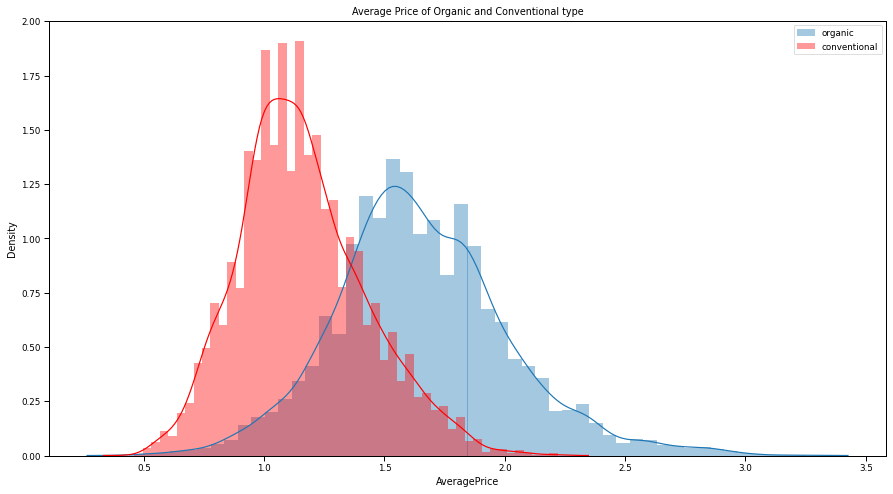

In [50]:
plt.figure(figsize = (15,8))
sns.distplot(df["AveragePrice"][df['type'] == 'organic'], label = 'organic')
sns.distplot(df["AveragePrice"][df['type'] == 'conventional'], label = 'conventional', color = 'red')
plt.title('Average Price of Organic and Conventional type')
plt.legend()
plt.savefig('avgprice.png')
plt.show()

This plot showed clearly the difference between avocado type price. Organic avocado seem to be high standard deviation because it stretched around mean [1.2, 3.25], also it have outliers. While conventional avocados is thinner then organic and its price located from 0.5 to 2.0

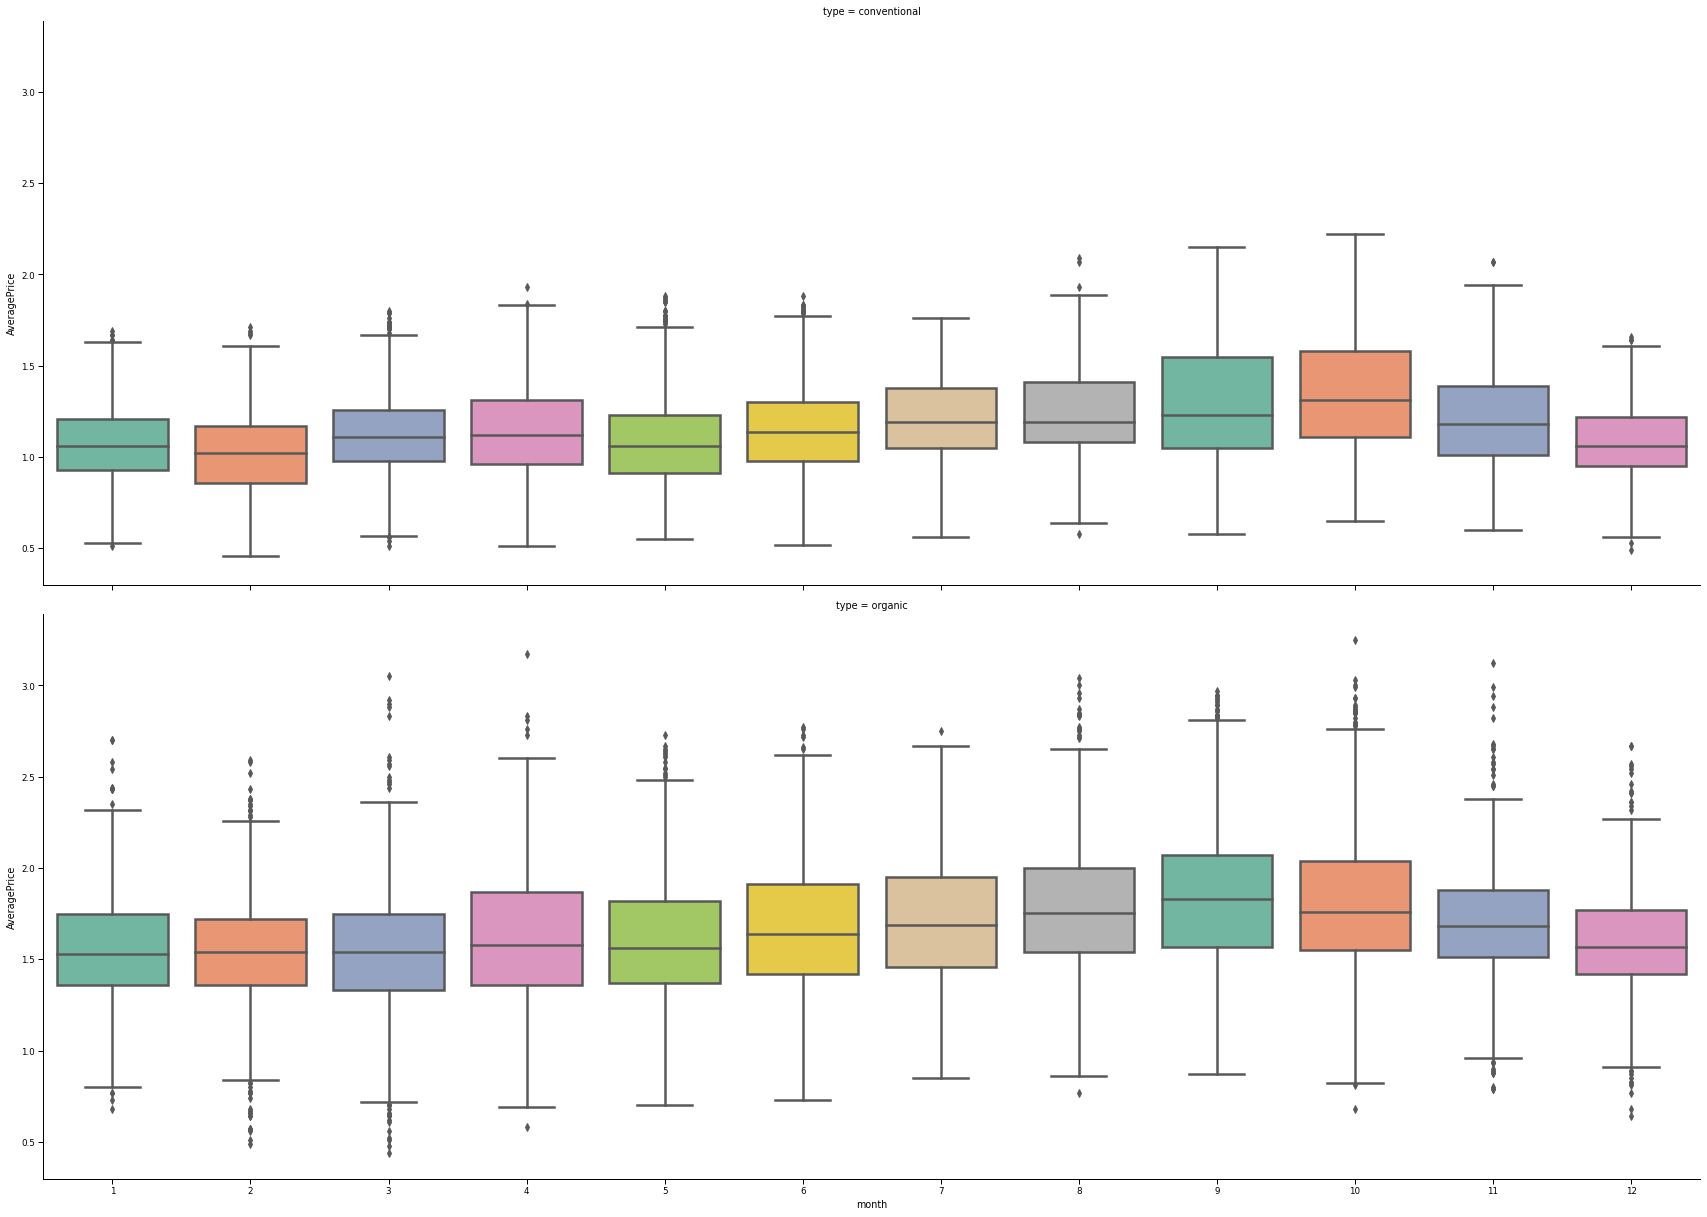

In [54]:
ax = sns.catplot(x="month", y="AveragePrice", row="type", 
            kind="box", data=df, height=8.5, linewidth=2.5, aspect=2.8,palette="Set2", sharey = True)

As I mentioned above, avocados transaction record begin rising from Sep until Dec, and its record rise (purchasing power increased) that's mean price increased also then droped down fastly from Oct to Dec.

<Figure size 1800x1080 with 0 Axes>

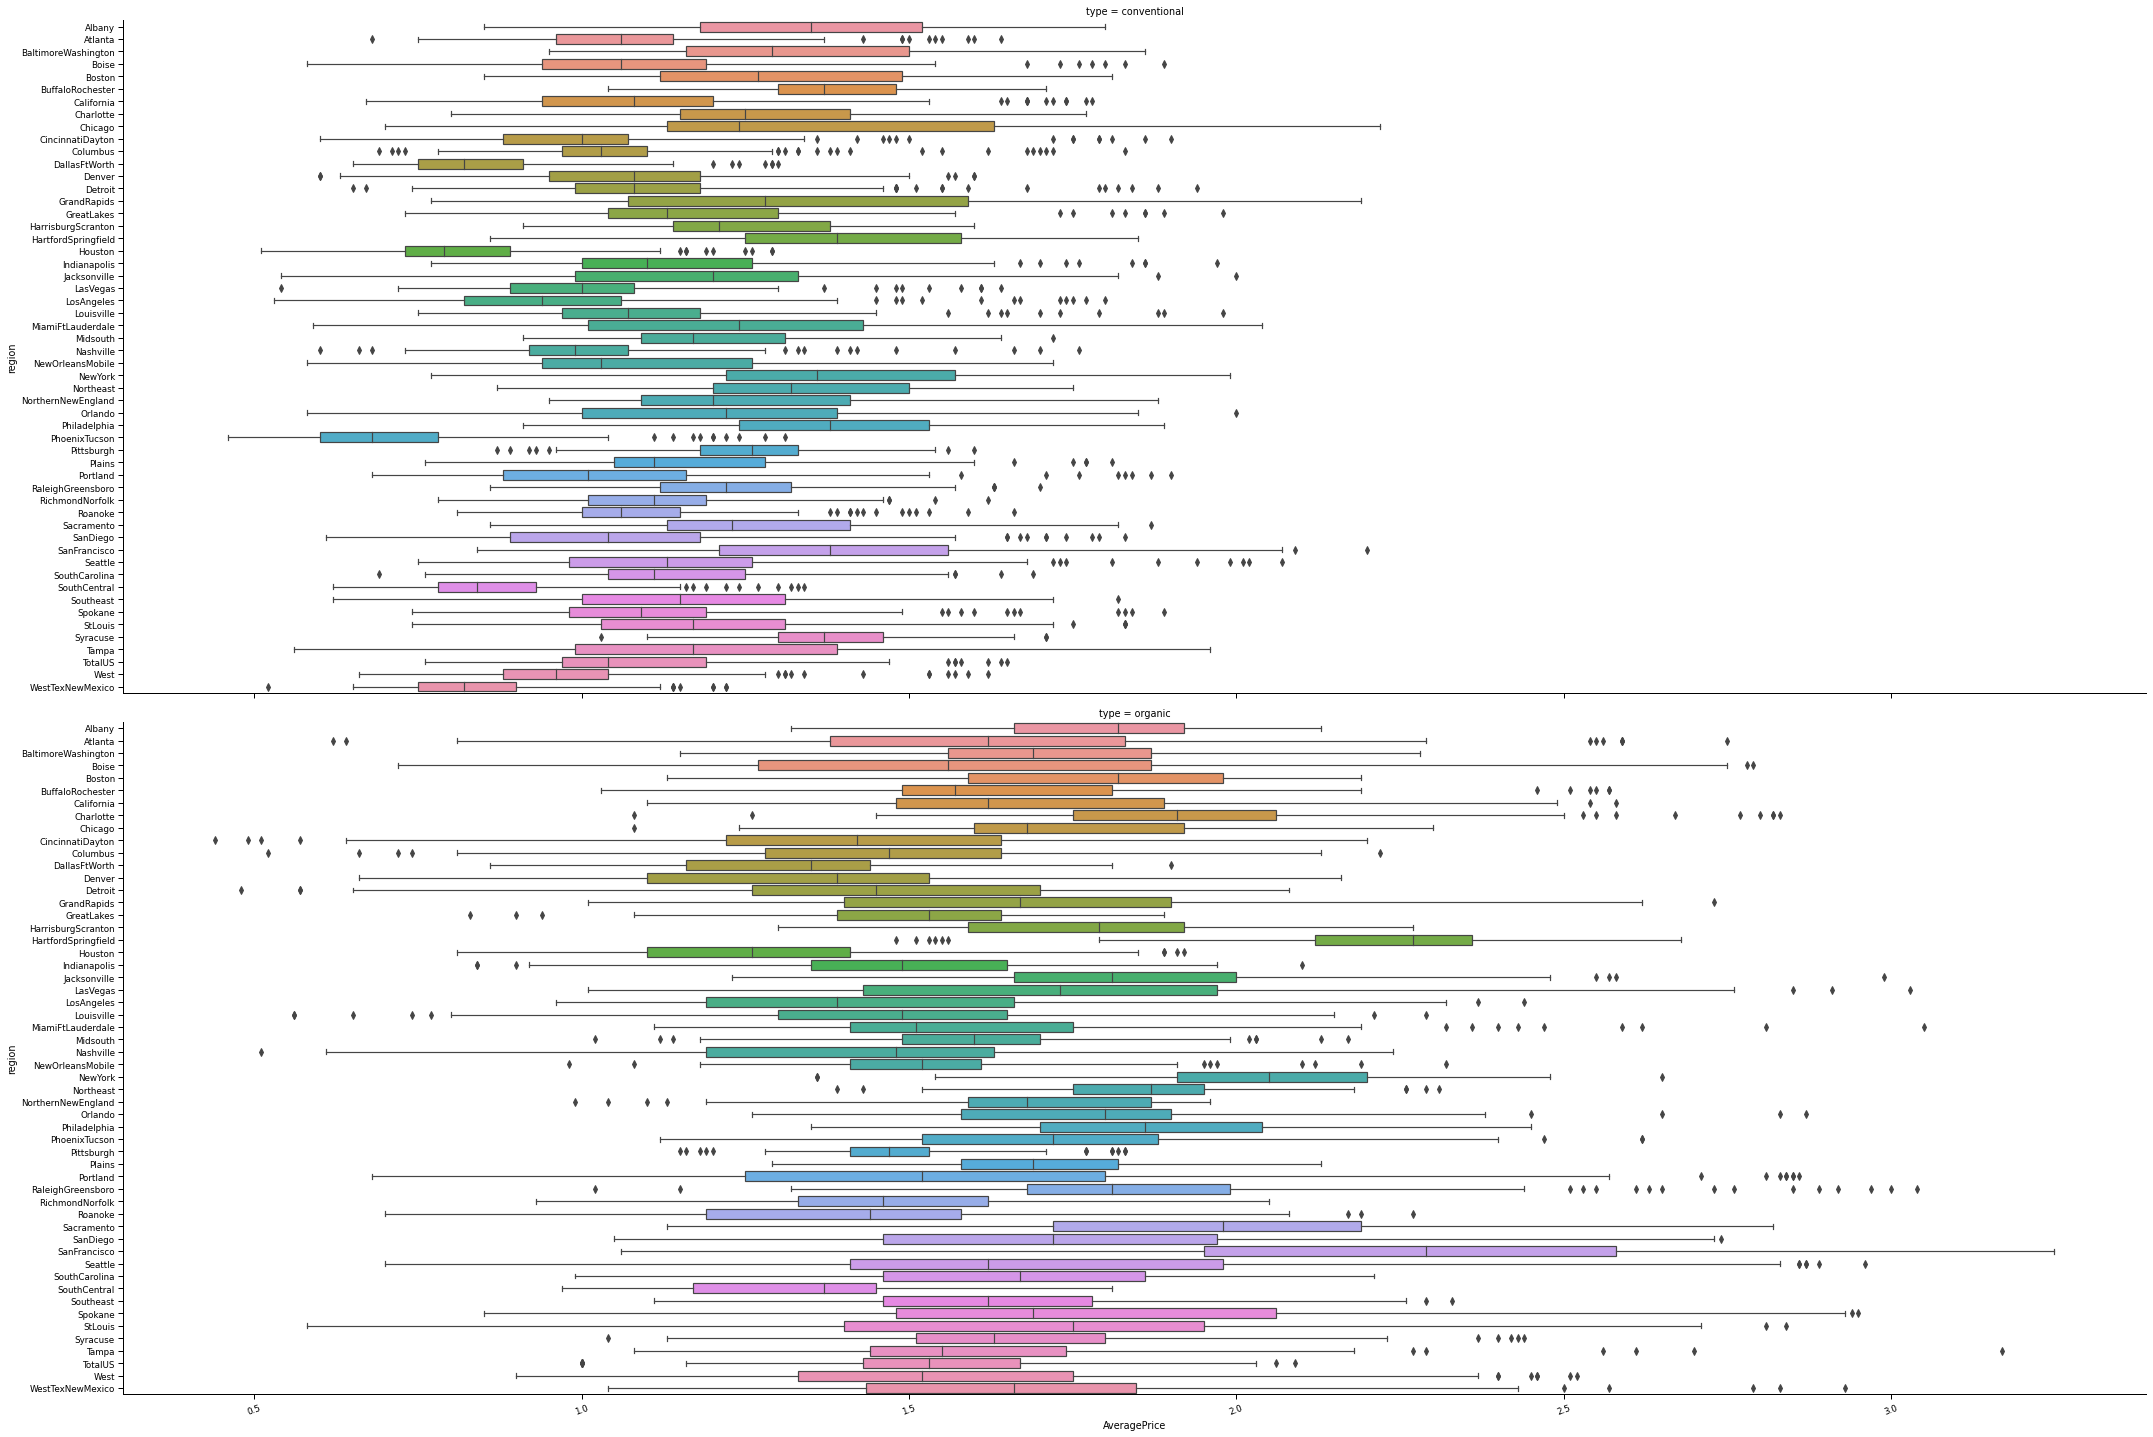

In [55]:
plt.figure(figsize = (25,15))
sns.catplot(y="region", x="AveragePrice",  
            kind="box", data=df, row = 'type',  height=10, aspect=3, ci = 0)
plt.xticks(rotation = 20)
plt.show()

c:\program files\python38\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\program files\python38\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\program files\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


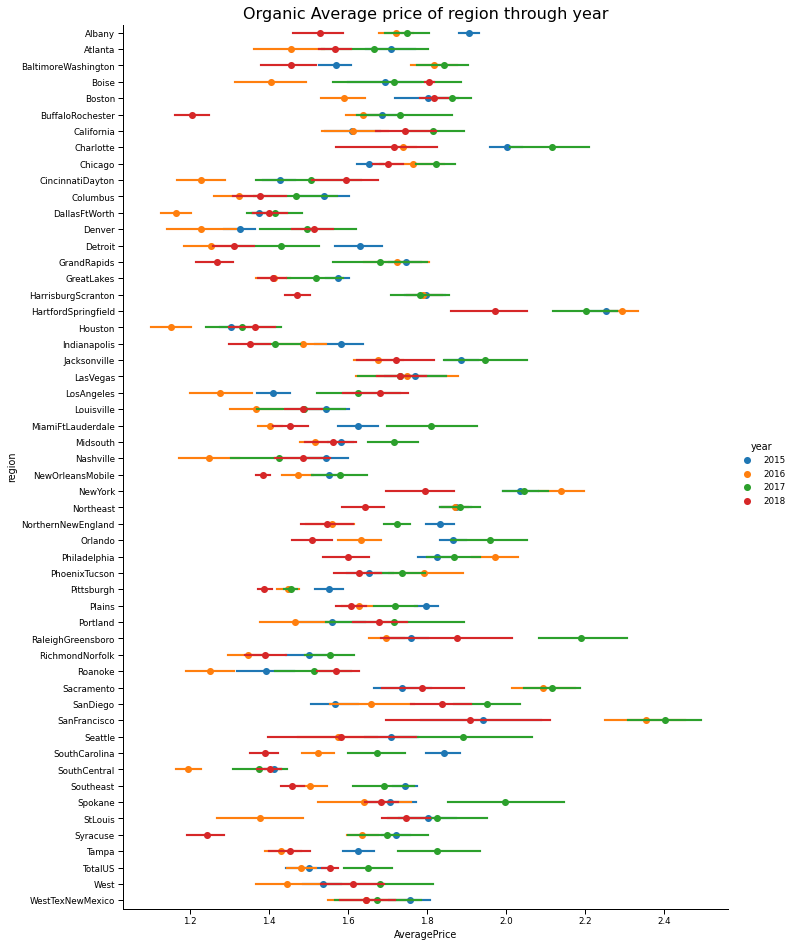

In [42]:
mask = df['type']=='organic'
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='tab10',
                   join=False,
              )
plt.title('Organic Average price of region through year', size = 16)
plt.savefig('factorplot1.png')

- As I said, organic product have a variety prices from 1.2 to 2.4, there are some region will be potential due to its price such as:
    - Houston: the price 2015 quite high and droped down really low in 2016 then rised up from 2017, and this still the bottom Agv price region.
    - Same case as Houston, we have SouthCentral, DallasFtWorth.
- The common ground of regions is the Organic Avage price droped down badly in 2016 and rised up in 2017. This case occurs clearly for those regions not so well known/sparsely populated. Or evenif that region is well known, may be consumer does not like avocados due to consumer behavior of that region.

c:\program files\python38\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\program files\python38\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\program files\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


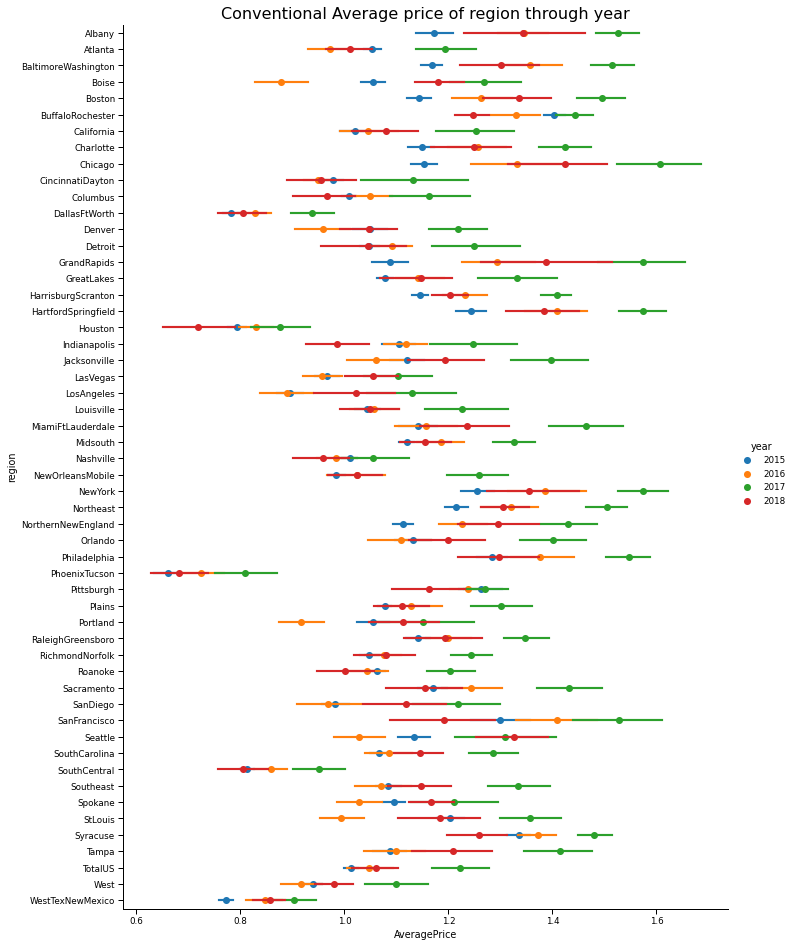

In [43]:
mask = df['type']=='conventional'
g = sns.factorplot('AveragePrice','region',data=df[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='tab10',
                   join=False,
              )
plt.title('Conventional Average price of region through year', size = 16)
plt.savefig('factorplot2.png')

- Conventional case is difference from Organic, because it have a large amount of consumption (> 300 mil per year) so the trend will be differ.
- Raised from 2015 to the lasted year (2017), the conventional seem to be popurality in all region. And the interesting point abot this case is most of region's Average price are nearly the same, and some big region on top of Organic Average price will have the Conventional Average price high also.

- The region we have to focus in this case (conventional) is Houston, DallasFTWorth and SouthCentral, same case as Organic

### Test the effect of X to y by using SelectKBest

In [ ]:
df_test = df.copy()

In [ ]:
label_encoder = LabelEncoder()
df_test['type'] = label_encoder.fit_transform(df_test['type'])
df_test['year'] = label_encoder.fit_transform(df_test['year'])
df_test['region'] = label_encoder.fit_transform(df_test['region'])
df_test

In [ ]:
X_for_test = df_test.drop(['Date','AveragePrice'], axis = 1)
y_for_test = df_test['AveragePrice']

In [ ]:
bestfeatures = SelectKBest(score_func=f_regression, k='all') # k=5
fit = bestfeatures.fit(X_for_test, y_for_test)
dfscores = pd.DataFrame(fit.scores_) # col: 0, 
dfcolumns = pd.DataFrame(X_for_test.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# Sorting in descending order 
featureScores.sort_values("Score", ascending = False, inplace = True)
print(featureScores)

- In this csae, type feature have the most effection to Avg Price.
- I will also select Total Volume and Total Bags for this model.

## 3. Data Preparation

### Select the data feature

In [58]:
#Data for regression problem
data = df.drop(['Date'], axis = 1)

In [59]:
data.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [60]:
data = data[data['region'] != 'TotalUS']

In [61]:
data.head()

AveragePrice  Total Volume  Small_hass  Large_hass  Xlarge_hass  \
0          1.33      64236.62     1036.74    54454.85        48.16   
1          1.35      54876.98      674.28    44638.81        58.33   
2          0.93     118220.22      794.70   109149.67       130.50   
3          1.08      78992.15     1132.00    71976.41        72.58   
4          1.28      51039.60      941.48    43838.39        75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  month  season  
0  Albany     12       3  
1  Albany     12       3  
2  Albany     12       3  
3  Albany     12       3  
4  Albany     11       2

In [62]:
df.shape[0] - data.shape[0]

338

### Data Cleaning

#### Impute missing values

In [63]:
data.isna().sum()

AveragePrice    0
Total Volume    0
Small_hass      0
Large_hass      0
Xlarge_hass     0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
month           0
season          0
dtype: int64

In [64]:
data.isnull().sum()

AveragePrice    0
Total Volume    0
Small_hass      0
Large_hass      0
Xlarge_hass     0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
month           0
season          0
dtype: int64

There is no nan & null data

In [65]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [66]:
missing_values_table(data)

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

#### Reduce noise in data

In [67]:
def outliers_detect(df ,f):
    Q1 = np.percentile(df[f], 25)
    Q3 = np.percentile(df[f], 75)

    upper_outlier = df[df[f] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
    lower_outlier = df[df[f] < (Q1 - 1.5*(Q3 - Q1))].shape[0]
    print('Percentage of outlier in dataset:', round(((upper_outlier+lower_outlier)/df.shape[0])*100,2),'%')
    print('Number of outliers in dataset:', upper_outlier + lower_outlier)

In [68]:
for i in nums:
    print('====================',i, '====================')
    outliers_detect(data,i)
    print()

==================== AveragePrice ====================
Percentage of outlier in dataset: 1.08 %
Number of outliers in dataset: 193

==================== Total Volume ====================
Percentage of outlier in dataset: 12.22 %
Number of outliers in dataset: 2189

==================== Small_hass ====================
Percentage of outlier in dataset: 13.68 %
Number of outliers in dataset: 2451

==================== Large_hass ====================
Percentage of outlier in dataset: 14.24 %
Number of outliers in dataset: 2551

==================== Xlarge_hass ====================
Percentage of outlier in dataset: 16.51 %
Number of outliers in dataset: 2957

==================== Total Bags ====================
Percentage of outlier in dataset: 13.03 %
Number of outliers in dataset: 2333

==================== Small Bags ====================
Percentage of outlier in dataset: 12.21 %
Number of outliers in dataset: 2187

==================== Large Bags ====================
Percentage of outlie

The data do not need to remove outliers because most of the feature are categorical, which mean it will best fit with Tree model than the others. We will make a test after normmalize and if the other model better than Tree model, then I will removed the outliers.

### Data Transformation

#### Normalize Data

In [93]:
df1 = data

In [94]:
df1.columns

Index(['AveragePrice', 'Total Volume', 'Small_hass', 'Large_hass',
       'Xlarge_hass', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags',
       'type', 'year', 'region', 'month', 'season'],
      dtype='object')

In [95]:
category_data = df1[['type', 'year', 'month', 'season']]

In [96]:
#Categories variable
#Binary for "type" feature (conventional = 1; organic = 0)
label_encode = preprocessing.LabelEncoder()
category_data['type'] = label_encode.fit_transform(category_data['type'])
category_data['year'] = label_encode.fit_transform(category_data['year'])
category_data = category_data.reset_index(drop = True)

In [97]:
category_data.head()

type  year  month  season
0     0     0     12       3
1     0     0     12       3
2     0     0     12       3
3     0     0     12       3
4     0     0     11       2

In [98]:
#onehot encode for year and region features
region_encode = pd.get_dummies(data = df1['region'], columns = ['region'])
region_encode = region_encode.reset_index(drop = True)

In [99]:
df1.shape

(17911, 14)

#### Feature Selection

In [100]:
#X contain Total Volume, Total Bags, type, year, region.
X = df1[['Total Volume', 'Total Bags']].reset_index(drop = True)
X_scaled = df1[['Total Volume', 'Total Bags']].reset_index(drop = True)
y = df1.AveragePrice

In [101]:
X.head()

Total Volume  Total Bags
0      64236.62     8696.87
1      54876.98     9505.56
2     118220.22     8145.35
3      78992.15     5811.16
4      51039.60     6183.95

In [102]:
y.head()

0   1.33
1   1.35
2   0.93
3   1.08
4   1.28
Name: AveragePrice, dtype: float64

In [78]:
#Feature scaling
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns = ['Total Volume', 'Total Bags'])

In [79]:
X_scaled.head()

Total Volume  Total Bags
0     -0.387996   -0.394907
1     -0.395640   -0.392689
2     -0.343902   -0.396420
3     -0.375943   -0.402822
4     -0.398775   -0.401800

This test case, I will apply StandardScaler on the whole X. The next test case will be only TotalVolume and Bags, I will keep the encode feature as binary value, also I will convert (labeled) the year feature. Will update later.

In [80]:
#X combination
X = pd.concat([X, category_data, region_encode], axis = 1)
X_scaled = pd.concat([X_scaled, category_data, region_encode], axis = 1)

In [82]:
X.to_csv('X.csv')

In [103]:
y.to_csv('y.csv')

## Modeling and Evaluating

### Modeling

### Lazy predict for modeling

In [83]:
from lazypredict.Supervised import LazyRegressor

C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_reg, prediction_reg = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models_reg

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 123)

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_reg, prediction_reg = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models_reg

In [ ]:
models = [
    ExtraTreesRegressor(n_estimators=100),
    RandomForestRegressor(n_estimators=100),
    XGBRegressor(n_estimators=100),
    DecisionTreeRegressor()
]
#loops
CV = 10
entries = []
i = 0
for time in range(0, 2):
    for model in models:
        scores_train = []
        scores_test = []
        mse_train = []
        mse_test = []
        times = []
        abs_scores = []
        accuracy_scores = []
        for j in range(CV):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
            t1 = datetime.datetime.now()
            model_name = model.__class__.__name__
            model.fit(X_train, y_train)
            t2 = datetime.datetime.now()
            d = round((t2-t1).microseconds/1000,1) #miliseconds
            
            yhat_train = model.predict(X_train)
            yhat_test = model.predict(X_test)
            score_train = model.score(X_train, y_train)
            score_test = model.score(X_test, y_test)
            abs_score = abs(score_train - score_test)
            mse_trains = mean_squared_error(y_train, yhat_train)
            mse_tests = mean_squared_error(y_test, yhat_test)
            
            scores_train.append(score_train)
            scores_test.append(score_test)
            abs_scores.append(abs_score)
            mse_train.append(mse_trains)
            mse_test.append(mse_tests)
            times.append(d)
        print(model.__class__.__name__, scores_test)
        entries.append([model_name, np.array(scores_train).mean(),
                    np.array(scores_test).mean(), np.array(abs_scores).mean(),
                    np.array(mse_train).mean(), np.array(mse_test).mean(),
                    np.array(times).mean()])
        i+=1
    cv_df = pd.DataFrame(entries, columns = ['model_name', 'score_train_mean',
                                          'score_test_mean', 'abs|score|','mean_mse_train', 'mean_mse_test' ,'time_mean'])
    cv_df

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(cv_df.groupby('model_name')['score_train_mean'].mean(),label = 'Mean of score train mean')
plt.plot(cv_df.groupby('model_name')['score_test_mean'].mean(), label = 'Mean of score test mean')
plt.ylim(0,1.2)
plt.xlabel('Model name')
plt.ylabel('Score test mean')
plt.xticks(rotation = 'vertical')
plt.title('Difference between train and test mean after running 10 times')
plt.legend()
plt.show()

- The R square of train value are pretty high with ExtraTrees model.
- the result above give the test r quare not high, the result seem overfitting, but still above 90% for ExtraTress is acceptable.

In [ ]:
cv_df.sort_values(by = 'abs|score|')

- The ExtraTrees and Forest have the best score, also with XGB when abs|score| is the lowest.
- I will select ExtraTrees due to the hiest test score.

#### Extratree Regressor

In [ ]:
test_size_lst = [0.15, 0.2, 0.25, 0.3, 0.35,0.4]
for i in test_size_lst:
    X_train1, X_test1, y_train1, y_test1 =  train_test_split(X, y, test_size = i, random_state = 42)
    etr = ExtraTreesRegressor()
    etr.fit(X_train1, y_train1)

    score_train = etr.score(X_train1, y_train1)
    score_test = etr.score(X_test1, y_test1)
    
    print('With[', 1-i,':',i,'], score train is', round(score_train,2), ', score test is', round(score_test,2), ', diff is:', round(abs(score_train - score_test),2))

In [ ]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42)

# Set the parameters by cross-validation
param_grid = [{'max_depth': [20, 40, 60, 80, 100],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 5],
              'n_estimators': [100, 150]}]

CV_etr= GridSearchCV(estimator=ExtraTreesRegressor(),
                      param_grid = param_grid, cv = 2)  #cv = 5 : run 5 times
CV_etr.fit(X_train, y_train)

In [ ]:
print("R-Squared::{}".format(CV_etr.best_score_))
print("Best Hyperparameters::\n{}".format(CV_etr.best_params_))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [87]:
#Use the parameter after Gridsearch
etr = ExtraTreesRegressor(max_depth= 60, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150)
etr.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=60, n_estimators=150)

In [88]:
import pickle
with open('extratree.pkl', 'wb') as pkl_extratree:
    pickle.dump(etr, pkl_extratree)

In [89]:
#predict y value from X_test
y_train_pred = etr.predict(X_train)
y_test_pred = etr.predict(X_test)

In [90]:
#Model evaluation
#score original data (R^2)
R_ori_multi = etr.score(X, y)
#score train
R_train_multi = etr.score(X_train, y_train)
#score test
R_test_multi = etr.score(X_test, y_test)

#mse original
mse_ori_multi = mean_squared_error(y, etr.predict(X))
#mse train
mse_train_multi = mean_squared_error(y_train, y_train_pred)
#mse test
mse_test_multi = mean_squared_error(y_test, y_test_pred)

#mae original
mae_ori_multi = mean_absolute_error(y, etr.predict(X))
#mae train
mae_train_multi = mean_absolute_error(y_train, y_train_pred)
#mae test
mae_test_multi = mean_absolute_error(y_test, y_test_pred)

print('R^2_original = ', R_ori_multi)
print('R^2_ train = ', R_train_multi)
print('R^2_ test = ', R_test_multi)
print()
print('MSE original = ', mse_ori_multi)
print('MSE train = ', mse_train_multi)
print('MSE test = ', mse_test_multi)
print()
print('MAE original= ', mae_ori_multi)
print('MAE train= ', mae_train_multi)
print('MAE test= ', mae_test_multi)

R^2_original =  0.985562449427659
R^2_ train =  0.9999965590658734
R^2_ test =  0.9286590595758895

MSE original =  0.002359260112403799
MSE train =  5.60602609643343e-07
MSE test =  0.011791424939735829

MAE original=  0.014615084169815523
MAE train=  0.0001764955654235204
MAE test=  0.07235331959368618


- In conclusion, the model need to be optimize more due to the result of test.
- In this case, the mse and mae score are low.
- All thing need to do is prepare the data carefully. I will try and update later.

#### Thank you very much for your time.

In [105]:
pd.read_csv('y.csv')

Unnamed: 0  AveragePrice
0               0          1.33
1               1          1.35
2               2          0.93
3               3          1.08
4               4          1.28
...           ...           ...
17906           7          1.63
17907           8          1.71
17908           9          1.87
17909          10          1.93
17910          11          1.62

[17911 rows x 2 columns]